In [1]:
import typing as T

from dataclasses import dataclass
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import xml
import xml.etree
import xml.etree.ElementTree

import hashlib
import shutil
import math
import cv2
import os

# pip3 install opencv_jupyter_ui
# See https://pypi.org/project/opencv-jupyter-ui/ if issues
# To view images in the notebook set max_images_display in the third big cell to a non-zero value and uncomment here
#import opencv_jupyter_ui as jcv2


@dataclass
class Segment:
    xmin: int;
    ymin: int;
    xmax: int;
    ymax: int;
    name: str;
    pose: str;
    # Not always present in dataset, so I just set to "None"
    segmented: int;
    truncated: int;
    difficult: int;

@dataclass
class Image:
    img_path: str;
    xml_path: str;
    xml_data: any;
    b_boxes:  T.List[Segment];



def get_images(i_dir: str, img_ext = ".JPG") -> T.List[Image]:
    """
    Returns all images within a directory (not recursive?)
    The code for figuring out if the rotation is correct is in a later block, but just check if xml size is equal to the opencv size, and rotate if not
    """
    images: T.List[Image] = [];

    entries = os.listdir(i_dir); # Throws if doesn't exist
    for file in entries:
        if (not file.endswith(".xml")): continue;

        xml_pth = os.path.join(i_dir, file);
        xml_data = xml.etree.ElementTree.parse(xml_pth);

        img_file = os.path.splitext(file)[0] + img_ext;
        if (not (img_file in entries)): continue;

        # Read boxes from the xml
        b_boxes: T.List[Segment] = [];

        for box in xml_data.findall("object"):
            bnd_box = box.find("bndbox");
            b_boxes.append(Segment(
                xmin=math.floor(float(bnd_box.findtext("xmin"))),
                ymin=math.floor(float(bnd_box.findtext("ymin"))),
                xmax=math.floor(float(bnd_box.findtext("xmax"))),
                ymax=math.floor(float(bnd_box.findtext("ymax"))),
                name=box.findtext("name"),
                pose=box.findtext("pose"),
                segmented=None,
                truncated=int(box.findtext("truncated")),
                difficult=int(box.findtext("difficult"))
            ));

        # We now have an XML+image pair so add it to our collection
        images.append(Image(
            img_path=os.path.join(i_dir, img_file),
            xml_path=xml_pth,
            xml_data=xml_data,
            b_boxes=b_boxes
        ));
    
    return images;


In [2]:
images: T.List[Image] = get_images("./traintogoin") + get_images("./validation");

In [3]:
images[0].xml_data.findall("object")[0].findtext("name")

'Cirsium arvense'

In [4]:
def cv_write_text(cv_image: cv2.typing.MatLike, text, org,
    color=(0,0,0),
    fontFace=cv2.FONT_HERSHEY_PLAIN,
    fontScale=4.25,
    thickness=5) -> None:
    """Writes text onto an image"""
    cv2.putText(cv_image,
        text=text,
        org=org,
        fontFace=fontFace,
        fontScale=fontScale,
        thickness=thickness,
        color=color
    );

def c_from_name(name: str, for_numpy = False, rgb=False) -> T.List[int]:
    """Get a colour from a hash"""
    # The python function "hash" does not give consistent results: https://stackoverflow.com/a/70498449
    hsh = int.from_bytes(hashlib.shake_128(name.encode(), usedforsecurity=False).digest(8), byteorder="big", signed=True);
    colour = ( math.floor(hsh / 256**2) % 255, math.floor(hsh / 256**3) % 255, math.floor(hsh / 256**4) % 255 );
    if (rgb or for_numpy): colour = ( colour[2], colour[1], colour[0] );
    
    if (not for_numpy): return colour
    else:
        return ( colour[0] / 256, colour[1] / 256, colour[2] / 256 );

In [19]:
# Should we try to fix images that might be broken due to xml/jpeg size difference through rotation of CCW90?
allow_rotate     = True;
# Should we shuffle the images (since we're only showing a subset)
shuffle_images      = True;
# Max number of images to read/write to disk
# max_images          = len(images);
max_images          = 200;
# Max number of images to write to jupyter output (using the special library in include)
max_images_display  = 0;
# The threshold where tags equals or exceeds when we log high tags 
high_tag_threshold = 70;


if (shuffle_images): np.random.shuffle(images);


# Learn some things about the dataset
processed_count = 0;
unc_mismatch_count = 0;
corrected_mismatch_count = 0;
unverified: T.List[str]  = [];
other_spp_imgs: T.List[str] = [];
high_tag_imgs: T.List[T.List[str | int]] = [];

img_size: T.Dict[T.Tuple[int], int] = {};
img_area: T.Dict[int, int]          = {};
species: T.Dict[str, int]           = {};
tags_p_img: T.Dict[int, int]        = {};

def inc_species(s_name: str) -> None:
    if (species.get(s_name) != None): species[s_name] += 1;
    else: species[s_name]                              = 1;

def inc_t_p_img(tags: str) -> None:
    if (tags_p_img.get(tags) != None): tags_p_img[tags] += 1;
    else:                              tags_p_img[tags]  = 1;

def inc_imgdeets(size: T.Tuple[int]) -> None:
    assert(len(size) == 2);

    area = np.prod(size);
    if (img_area.get(area) != None): img_area[area] += 1;
    else:                            img_area[area]  = 1;
    
    if (img_size.get(size) != None): img_size[size] += 1;
    else:                            img_size[size]  = 1;


In [20]:
#
# Process all the images
#   Make sure to run the above block fist if re-running to reset stats
#   Is very slow, will take 2+ mins to run on all images
#

for i, img in enumerate(images[0:max_images]):
    cv_image = cv2.imread(img.img_path);

    #
    # Printing details onto image and correcting rotation
    #

    # Try to approximate if we've received a flipped image
    # XML width/height inverted compared to OpenCV
    img_d_size = (int(img.xml_data.find("size").findtext("height")), int(img.xml_data.find("size").findtext("width")));
    # These landscape flags are a waste of time, I wrote them expecting there
    # to be the occasional image with a size (area) disparity like if they'd cropped or resized images
    d_landscape = 1 < (img_d_size[0] / img_d_size[1]);
    i_landscape = 1 < (cv_image.shape[0] / cv_image.shape[1]);
    has_rotated_image = False;

    if ((d_landscape != i_landscape) and allow_rotate):
        cv_image = cv2.rotate(cv_image, cv2.ROTATE_90_COUNTERCLOCKWISE);
        has_rotated_image=True;
        # Stats
        corrected_mismatch_count += 1;
    
    if (cv_image.shape[0:2] != img_d_size):
        print(f"Image size mismatch between xml & jpeg for {img.xml_path} xml: {img_d_size}, jpg: {cv_image.shape[0:2]}");
        # Stats
        unc_mismatch_count += 1;
    
    # Record an occurrence of this image size
    inc_imgdeets(cv_image.shape[0:2]);

    # Read the "verified" attribute
    verified = img.xml_data.getroot().attrib["verified"];

    if (verified != "yes"):
        print(f"{img.xml_path} is unverified with status of {verified}");
        # Stats (reporting)
        unverified.append(img.xml_path);
    
    # Write an (approximate) box for readability
    cv2.rectangle(cv_image,
        pt1=(0,0),
        pt2=(470,205),
        color=(255, 255, 255),
        thickness=-1
    );
    cv_write_text(cv_image, f"Verified: {verified}", org=(0, 50), color=(0,255,0) if (verified == "yes") else (255, 0, 0));
    cv_write_text(cv_image, f"img_size: {cv_image.shape}", org=(0, 100), fontScale=2.25);
    cv_write_text(cv_image, f"xml_size: {img_d_size}", org=(0, 150), fontScale=2.25);
    if (has_rotated_image): cv_write_text(cv_image, "Rotated image", org=(0,200), color=(255,127,127));

    #
    # Add bounding boxes
    #

    # Stats
    inc_t_p_img(len(img.b_boxes));

    if (len(img.b_boxes) >= high_tag_threshold):
        high_tag_imgs.append([img.img_path, len(img.b_boxes)]);

    for box in img.b_boxes:
        # Stats (reporting)
        if (box.name == "other spp."): other_spp_imgs.append(img.img_path);
        
        # Record an occurrence of a species
        inc_species(box.name);

        # Get a unique colour for this species
        name_c = c_from_name(box.name);
        
        # Draw a bounding box
        cv2.rectangle(
            cv_image,
            pt1=(box.xmin, box.ymin),
            pt2=(box.xmax, box.ymax),
            color=name_c,
            thickness=8
        );
        # Annotate the box
        text_size = cv2.getTextSize(box.name,fontFace=cv2.FONT_HERSHEY_PLAIN,fontScale=4.25,thickness=5)[0];
        cv2.rectangle(
            cv_image,
            pt1=(box.xmin, box.ymin - text_size[1]),
            pt2=(box.xmin + text_size[0], box.ymin),
            color=name_c,
            thickness=-1
        );
        cv_write_text(cv_image, box.name, org=(box.xmin, box.ymin), color=(name_c[0]^255, name_c[1]^255, name_c[2]^255)); # Bitwise not the colour for text

    #
    # I/O
    #

    # Save all the images with bounding boxes to disk
    cv2.imwrite(img.img_path + ".boxed.jpg", cv_image);

    # We shouldn't need to do this, but may as well for parity
    processed_count += 1;
    
    # Only write some images to Jupyter
    if (i < max_images_display):
        # Display the image within Jupyter
        # Don't need to comment out if not using library, just set max_images_display = 0
        jcv2.imshow(img.xml_path, cv_image, width=768);

In [21]:
# processed_count = 0;
# unc_mismatch_count = 0;
# corrected_mismatch_count = 0;
# unverified: T.List[str] = [];

# img_size: T.Dict[T.Tuple[int], int] = {};
# img_area: T.Dict[int, int]             = {};
# species: T.Dict[str, int]              = {};

if (processed_count != len(images)):
    print(f'Processed {processed_count} {"randomly shuffled" if (shuffle_images) else "incremental"} images.');
else:
    print(f"Processed all {len(images)} images");
print(f'There were {unc_mismatch_count} uncorrected size mismatches, and {corrected_mismatch_count} images were rotated to account for size disparity');
print(f'We found {len(unverified)} images without the verification attribute as "yes". These were: {unverified}');


i_sizes_df = pd.DataFrame(data={"size": img_size.keys(), "count": img_size.values()}).sort_values("count");
i_areas_df = pd.DataFrame(data={"area": img_area.keys(), "count": img_area.values()}).sort_values("count");
species_df = pd.DataFrame(data={"species": species.keys(), "count": species.values()}).sort_values("count");
t_p_img_df = pd.DataFrame(data={"tags": tags_p_img.keys(), "count": tags_p_img.values()}).sort_values("count");

display(i_sizes_df);
display(i_areas_df);
display(species_df);
display(t_p_img_df);

print(f'We recorded {species_df["count"].sum()} bounding boxes');

def plot_barh_species(sdf):
    plt.barh(y=sdf["species"], width=sdf["count"], color=[ c_from_name(s, True) for s in sdf["species"] ] );
    plt.show();

print(f'Images containing an other spp. classification: {other_spp_imgs}');
print(f'Images with large tag count (tag ≥ {high_tag_threshold}):');
high_tag_imgs

Processed 200 randomly shuffled images.
There were 0 uncorrected size mismatches, and 81 images were rotated to account for size disparity
We found 0 images without the verification attribute as "yes". These were: []


,size,count
2,"(2816, 2112)",1
1,"(1368, 1824)",10
0,"(2112, 2816)",189


,area,count
1,2495232,10
0,5947392,190


,species,count
25,other spp.,3
12,Taraxacum agg.,21
24,Knautia arvensis,33
22,Achillea millefolium,36
23,Lathyrus pratensis,48
18,Symphytum officinale,59
19,Rhinanthus minor,60
21,Prunella vulgaris,71
7,Centaurea nigra,76
14,Cirsium vulgare,79


,tags,count
46,48,1
27,32,1
16,47,1
28,20,1
29,35,1
30,53,1
32,36,1
11,45,1
37,38,1
35,37,1


We recorded 2734 bounding boxes
Images containing an other spp. classification: ['./validation/IMG_3184.JPG', './validation/IMG_3184.JPG', './traintogoin/IMG_3377.JPG']
Images with large tag count (tag ≥ 70):


[['./traintogoin/IMG_3220.JPG', 75]]

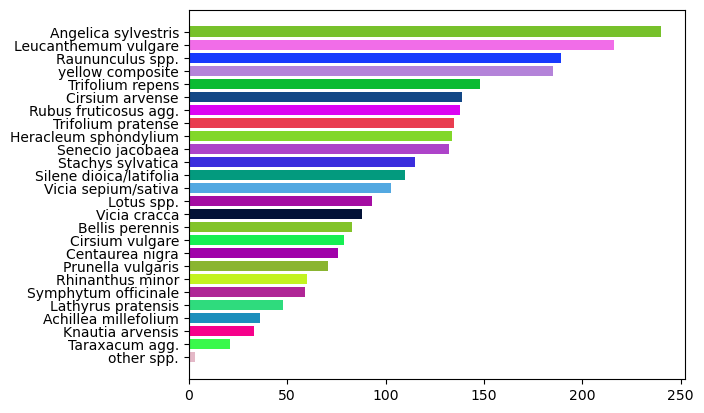

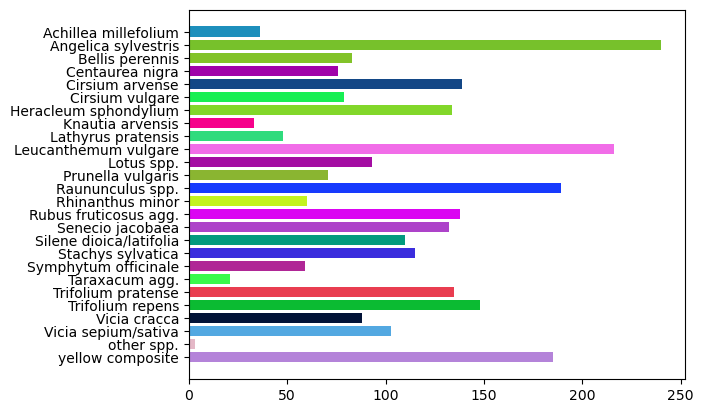

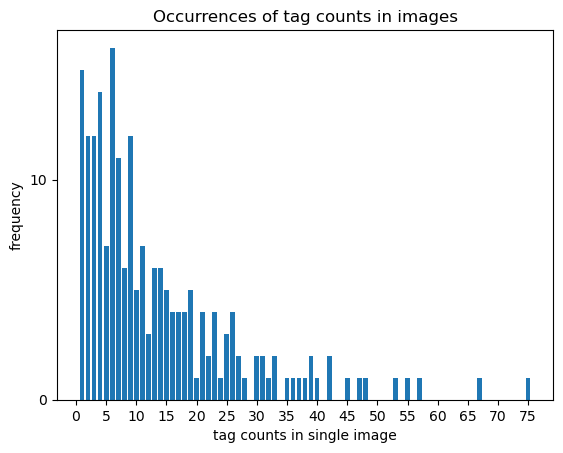

In [22]:
# Plot the species
plot_barh_species(species_df);
# Also sort alphabetically for both a colour look-up table and to determine if there are duplicate class names
plot_barh_species(species_df.sort_values(by="species", ascending=False));
# Distribution of tags/image
plt.bar(t_p_img_df["tags"], t_p_img_df["count"]);
plt.xlabel("tag counts in single image");
plt.ylabel("frequency");
plt.xticks(np.arange(0, 90, 5));
plt.yticks(np.arange(0, 170, 10));
plt.title("Occurrences of tag counts in images");
plt.plot();

In [23]:
#
# Create a directory on the filesystem which has just symlinks to the "boxed" images
#

boxed_dir = "./boxed_imgs";

if (os.path.exists(boxed_dir)):
    # rm -r in python taken from https://stackoverflow.com/a/43757091
    shutil.rmtree(boxed_dir);

os.mkdir(boxed_dir);

# Make a symlink for each of the images we've processed
for img in images[0:max_images]:
    img_pth = img.img_path + ".boxed.jpg";
    ln_dir  = os.path.join(boxed_dir, os.path.dirname(img_pth));

    if (not os.path.isdir( ln_dir )):
        os.makedirs( ln_dir );
    
    os.symlink(os.path.abspath(img_pth), os.path.join(boxed_dir, img_pth));

In [24]:
species_col  = species_df.sort_values(by="count", ascending=False).reset_index()["species"];
species_list = list(species_col);
species_map  = {};

for i, sp in enumerate(species_list):
    species_map.update( { sp: i } );

species_map

{'Angelica sylvestris': 0,
 'Leucanthemum vulgare': 1,
 'Raununculus spp.': 2,
 'yellow composite': 3,
 'Trifolium repens': 4,
 'Cirsium arvense': 5,
 'Rubus fruticosus agg.': 6,
 'Trifolium pratense': 7,
 'Heracleum sphondylium': 8,
 'Senecio jacobaea': 9,
 'Stachys sylvatica': 10,
 'Silene dioica/latifolia': 11,
 'Vicia sepium/sativa': 12,
 'Lotus spp.': 13,
 'Vicia cracca': 14,
 'Bellis perennis': 15,
 'Cirsium vulgare': 16,
 'Centaurea nigra': 17,
 'Prunella vulgaris': 18,
 'Rhinanthus minor': 19,
 'Symphytum officinale': 20,
 'Lathyrus pratensis': 21,
 'Achillea millefolium': 22,
 'Knautia arvensis': 23,
 'Taraxacum agg.': 24,
 'other spp.': 25}

In [25]:
# Define a struct fot the dataset json used in Adrian's code

@dataclass
class A_Annotation:
    # ID of this annotation?
    id: int;
    # ID of the relevant image
    image_id: int;
    # List of 4 ints
    bbox: T.List[int];
    # Id of the category
    category_id: int;

    # This is seemingly always 1.0
    # Need to look further into code
    area: float;
    # Unsure
    iscrowd: int;

@dataclass
class A_Category:
    # ID of category
    id: int;
    name: str;
    supercategory: str;

@dataclass
class A_Image:
    id: int;
    file_name: str;
    width: int;
    height: int;
    
@dataclass
class A_Dataset:
    annotations: T.List[A_Annotation];
    categories: T.List[A_Category];
    images: T.List[A_Image];



In [26]:
# Create the dataset and add the categories
ads = A_Dataset([], [], []);

# for i, sp in enumerate(species_list):
# Select the 4 classes with the most instances
allowed_classes = list(species_map.keys())[0:4];

for i, sp in enumerate(allowed_classes):
    ads.categories.append( A_Category(i, sp, sp) );

# Add all of the images and their bounding boxes

new_dataset_path = "./json_ds";
if (os.path.exists(new_dataset_path)):
    # rm -r in python taken from https://stackoverflow.com/a/43757091
    shutil.rmtree(new_dataset_path);

os.mkdir(new_dataset_path);
os.mkdir(os.path.join(new_dataset_path, "traintogoin"));
os.mkdir(os.path.join(new_dataset_path, "validation"));


bbox_id = 0;

for img_id, img in enumerate(images[0:max_images]):
    # Fist bit copied from earlier block
    cv_image = cv2.imread(img.img_path);
        
    # print(img.img_path)

    # Try to approximate if we've received a flipped image
    # XML width/height inverted compared to OpenCV
    img_d_size = (int(img.xml_data.find("size").findtext("height")), int(img.xml_data.find("size").findtext("width")));
    # These landscape flags are a waste of time, I wrote them expecting there
    # to be the occasional image with a size (area) disparity like if they'd cropped or resized images
    d_landscape = 1 < (img_d_size[0] / img_d_size[1]);
    i_landscape = 1 < (cv_image.shape[0] / cv_image.shape[1]);
    has_rotated_image = False;

    if ((d_landscape != i_landscape) and allow_rotate):
        cv_image = cv2.rotate(cv_image, cv2.ROTATE_90_COUNTERCLOCKWISE);
        has_rotated_image=True;

    if (cv_image.shape != (2112, 2816, 3)): continue;

    # Save the rotated image to disk if it's rotated
    if (has_rotated_image):
        cv2.imwrite( os.path.join(new_dataset_path, img.img_path), cv_image);
    else:
        # Otherwise, make a symbolic link
        ln_dir = os.path.join(os.path.abspath(new_dataset_path), os.path.dirname(img.img_path));

        if (not os.path.isdir( ln_dir )):
            os.makedirs( ln_dir );
        
        os.symlink(
            os.path.abspath(img.img_path),
            os.path.join(os.path.abspath(new_dataset_path), img.img_path)
        );

    # Create entries in our new dataset format
    ads.images.append(A_Image(
        img_id,
        img.img_path,
        cv_image.shape[1],
        cv_image.shape[0]
    ));

    # Add this image's bounding boxes
    density_bboxes = [ [] for c in allowed_classes ];
    for bbox in img.b_boxes:
        # Only allow some species to reduce the size
        if ( not (bbox.name in allowed_classes) ): continue;
        
        class_index = allowed_classes.index(bbox.name);
        density_bboxes[class_index].append([bbox.xmin, bbox.ymin]);
        density_bboxes[class_index].append([bbox.xmax, bbox.ymax]);
        ads.annotations.append(A_Annotation(
            id=bbox_id,
            image_id=img_id,
            bbox=[ bbox.xmin, bbox.ymin, bbox.xmax, bbox.ymax ],
            category_id=species_map[bbox.name],
            area=1.0,
            iscrowd=0
        ));
        
        bbox_id += 1;
    
    for i, c in enumerate(allowed_classes):
        np.savetxt(os.path.join(new_dataset_path, img.img_path) + f"_c{i}.txt", density_bboxes[i]);


# # Make a symlink for each of the images we've processed
# for img in images[0:max_images]:
#     img_pth = img.img_path + ".boxed.jpg";
#     ln_dir  = os.path.join(boxed_dir, os.path.dirname(img_pth));

#     if (not os.path.isdir( ln_dir )):
#         os.makedirs( ln_dir );
    
#     os.symlink(os.path.abspath(img_pth), os.path.join(boxed_dir, img_pth));
    

In [27]:
import json

json_ds_handle = open(os.path.join( new_dataset_path, "dataset.json" ), "w");

# JSON serialise class solution from this S/O comment: https://stackoverflow.com/questions/10252010/serializing-class-instance-to-json#comment82536156_10252010
json_ds_handle.write(json.dumps(ads, default=lambda x: x.__dict__, indent=4));
json_ds_handle.flush();
json_ds_handle.close();